In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import numpy as np
from matplotlib import pyplot as plt

In [0]:
def intensity_baseline(period, amplitude, phase, t):
  return amplitude * np.sin((2 * np.pi * t / period) + phase)

In [0]:
def lens_magnification(u0, t0, tE, t):
  ut = u0 + np.abs((t - t0) / tE)
  return (ut ** 2 + 2) / (ut * np.sqrt(ut**2 + 4))

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def intensity_baseline(period, amplitude, phase, t):
  return amplitude * np.sin((2 * np.pi * t / period) + phase)


def lens_magnification(u0, t0, tE, t):
  ut = u0 + np.abs((t - t0) / tE)
  return (ut ** 2 + 2) / (ut * np.sqrt(ut**2 + 4))


def simulate_microlensing(baseline_period, baseline_amplitude, baseline_phase,
                          lens_min_impact, lens_shift, lens_radius, noise, t_range=range(100)):
  i_s0 = np.array([intensity_baseline(baseline_period, baseline_amplitude, baseline_phase, t) for t in t_range])
  i_A = np.array([lens_magnification(lens_min_impact, lens_shift, lens_radius, t) for t in t_range])
  n = np.random.normal(scale=noise, size=len(t_range))
  return i_s0 + i_A + n

# Generate Train and Test Data

In [0]:
def simulate_noevent(baseline_period, baseline_amplitude, baseline_phase, noise, t_range=range(100)):
    i_s0 = np.array([intensity_baseline(baseline_period, baseline_amplitude, baseline_phase, t) for t in t_range])
    n = np.random.normal(scale=noise, size=len(t_range))
    return i_s0 + n

In [0]:
from tqdm import tqdm

def generate_dataset(num_dataset, max_t=100, predict_window=30, produce_sim=True):
    X_out = np.zeros((num_dataset, max_t, 2))
    y_out = np.zeros((num_dataset, max_t))

    for x in tqdm(range(num_dataset)):
        seq=None
        ys=None
        if np.random.uniform() > 0.5:
            peak_t = int(np.random.uniform(low=predict_window+10, 
                                           high=max_t-predict_window-10))
            seq = simulate_microlensing(baseline_period=2, 
                                        baseline_amplitude=0.0001, 
                                        baseline_phase=0,
                                        lens_min_impact=10, 
                                        lens_shift=peak_t, 
                                        lens_radius=1, 
                                        noise=0.00001, 
                                        t_range=range(max_t))
            seq_avg = np.mean(seq[:predict_window])
            seq_std = np.std(seq[:predict_window])
            seq = (seq - seq_avg) / seq_std
            ys = np.zeros(max_t)
            ys[peak_t-10:peak_t+10] = 1
        else:
            seq = simulate_noevent(baseline_period=2, 
                                baseline_amplitude=0.0001,
                                baseline_phase=0,
                                noise=0.00001,
                                t_range=range(max_t))
            seq_avg = np.mean(seq[:predict_window])
            seq_std = np.std(seq[:predict_window])
            seq = (seq - seq_avg) / seq_std
            ys = np.zeros(max_t)
        if produce_sim:
            model=pf.ARIMA(data=seq,ar=2, integ=1, ma=2, family=pf.Normal())
            model.fit('MLE')
            hs = model.predict_is(h=(max_t-predict_window))
            seq_sim = np.concatenate((seq[:predict_window], hs['Differenced Series']))
        else:
            seq_sim = seq
        X_out[x,:,0] = seq
        X_out[x,:,1] = seq_sim
        y_out[x] = ys
    
    return X_out, y_out

In [8]:
np.random.seed(420)
X_train, y_train = generate_dataset(5000, max_t=1000, predict_window=200, produce_sim=False)

100%|██████████| 5000/5000 [00:18<00:00, 267.74it/s]


In [9]:
np.random.seed(520)
X_test, y_test = generate_dataset(100, max_t=1000, predict_window=200, produce_sim=False)

100%|██████████| 100/100 [00:00<00:00, 239.54it/s]


# Injecting the residuals into LSTM 

Building the LSTM model

In [0]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
import tensorflow as tf
from tensorflow.keras import layers

In [0]:
# Initialising the RNN
rnn_lstm = tf.keras.Sequential()

In [0]:
# Adding the LSTM layers and some Dropout regularisation

# Adding the first layer
rnn_lstm.add(layers.LSTM(units=200, return_sequences=True, input_shape=(None, 2)))
rnn_lstm.add(layers.Dropout(0.2))

rnn_lstm.add(layers.LSTM(units=100, return_sequences=True, input_shape=(None, 200)))
rnn_lstm.add(layers.Dropout(0.2))

# Output layer
rnn_lstm.add(layers.Dense(units=1, activation='sigmoid'))

In [19]:
# Compiling the RNN
rnn_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', f1_m])
rnn_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 200)         162400    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 100)         120400    
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           101       
Total params: 282,901
Trainable params: 282,901
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Fitting the RNN to training set
rnn_lstm.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), verbose=1)

Train on 5000 samples, validate on 100 samples
Epoch 1/10
5000/5000 [==============================] - 18s 4ms/sample - loss: 0.0395 - acc: 0.9922 - f1_m: 0.7384 - val_loss: 0.0115 - val_acc: 0.9974 - val_f1_m: 0.8622
Epoch 2/10
5000/5000 [==============================] - 15s 3ms/sample - loss: 0.0098 - acc: 0.9979 - f1_m: 0.8874 - val_loss: 0.0094 - val_acc: 0.9979 - val_f1_m: 0.8925
Epoch 3/10
5000/5000 [==============================] - 15s 3ms/sample - loss: 0.0090 - acc: 0.9981 - f1_m: 0.9006 - val_loss: 0.0092 - val_acc: 0.9980 - val_f1_m: 0.8934
Epoch 4/10
5000/5000 [==============================] - 15s 3ms/sample - loss: 0.0081 - acc: 0.9983 - f1_m: 0.9070 - val_loss: 0.0080 - val_acc: 0.9983 - val_f1_m: 0.9184
Epoch 5/10
5000/5000 [==============================] - 14s 3ms/sample - loss: 0.0076 - acc: 0.9983 - f1_m: 0.9109 - val_loss: 0.0075 - val_acc: 0.9982 - val_f1_m: 0.9182
Epoch 6/10
5000/5000 [==============================] - 14s 3ms/sample - loss: 0.0073 - acc: 0.998

In [21]:
rnn_lstm.evaluate(X_test, y_test)

100/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.0066917992103844885, 0.99840003, 0.9196445]

In [22]:
sum(sum(y_test)) / 1000

1.02

In [0]:
y_pred=rnn_lstm.predict_proba(X_test)

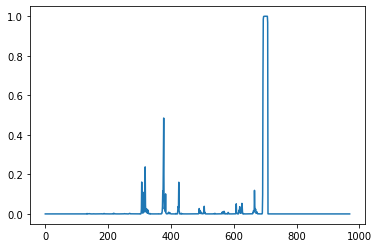

In [24]:
plt.plot(y_pred[4][30:])

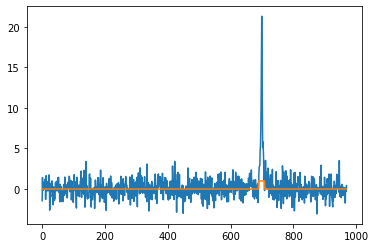

In [25]:
plt.plot(X_test[4,:,0][30:])
plt.plot(y_test[4][30:])

# Evaluation


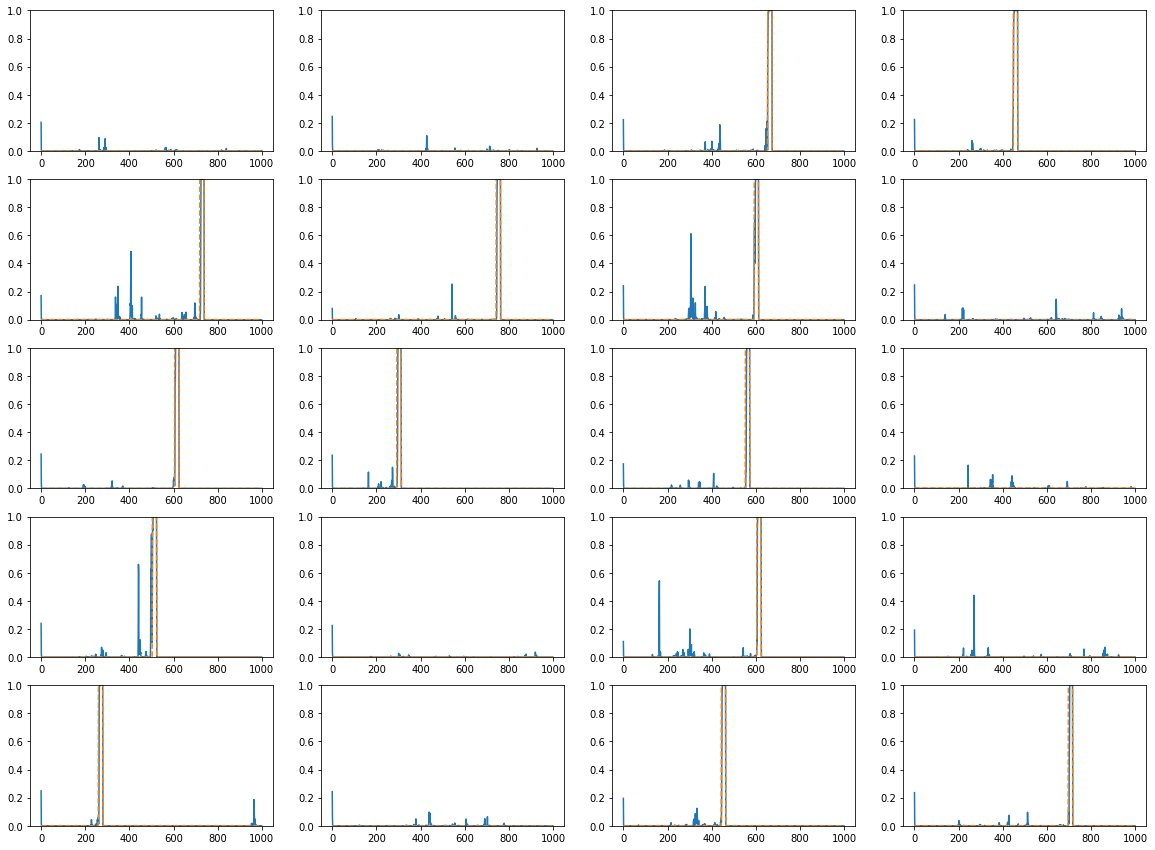

In [26]:
# Generate predictions.
y_pred=rnn_lstm.predict_proba(X_test)

plt.figure(figsize=(20,15))

for i in range(20):
    plt.subplot(5,4,i+1)
    plt.plot(y_pred[i])
    plt.plot(y_test[i],'--')
    plt.ylim(0,1)

plt.show()